# Módulo 8 - Regressão Linear Múltipla



In [67]:
# AED
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Model Trainning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Model Validation
from scipy.stats import zscore, shapiro, kstest, anderson
from statsmodels.stats.diagnostic import lilliefors, het_goldfeldquandt
import pingouin as pg

# Model Prediction
import joblib

### AED



#### Carga do Dados



Nesta aula, aprendemos a importância de trabalhar com nomes de colunas mais técnicos em um DataFrame. Isso facilita a referência e evita confusões com acentuação, maiúsculas e minúsculas. Aprendemos a renomear as colunas usando o atributo "columns" do DataFrame, atribuindo uma lista com os novos nomes das colunas desejadas. Também aprendemos sobre o conceito de Bucketing, que consiste em transformar variáveis numéricas em variáveis categóricas para análises específicas. Para isso, fizemos cópias do DataFrame original para trabalhar na análise exploratória e no Bucketing, deixando o DataFrame original intacto para o treinamento do modelo.



In [2]:
# carregar o dataset
df_colesterol = pd.read_csv("../datasets/dataset_colesterol.csv")
df_colesterol.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  1000 non-null   int64  
 1   Grupo Sanguíneo     996 non-null    object 
 2   Fumante             997 non-null    object 
 3   Nível de Atividade  996 non-null    object 
 4   Idade               997 non-null    float64
 5   Peso                997 non-null    float64
 6   Altura              997 non-null    float64
 7   Colesterol          1000 non-null   float64
dtypes: float64(4), int64(1), object(3)
memory usage: 62.6+ KB


In [3]:
# remover coluna "Id"
df_colesterol.drop(columns=["Id"], axis=1, inplace=True)
df_colesterol.head(3)

,Grupo Sanguíneo,Fumante,Nível de Atividade,Idade,Peso,Altura,Colesterol
0,B,Sim,Baixo,33.0,85.1,186.0,199.63
1,A,Não,Moderado,68.0,105.0,184.0,236.98
2,O,Não,Alto,25.0,64.8,180.0,161.79


In [4]:
# renomear colunas
df_colesterol.columns = [
    "grupo_sanguineo",
    "fumante",
    "nivel_atividade_fisica",
    "idade",
    "peso",
    "altura",
    "nivel_colesterol",
]

In [5]:
# copiar DF para DF AED
df_colesterol_eda = df_colesterol.copy()
df_colesterol_eda.head(2)

,grupo_sanguineo,fumante,nivel_atividade_fisica,idade,peso,altura,nivel_colesterol
0,B,Sim,Baixo,33.0,85.1,186.0,199.63
1,A,Não,Moderado,68.0,105.0,184.0,236.98


In [6]:
# copiar DF para DF Bucketing
df_colesterol_bucketing = df_colesterol.copy()
df_colesterol_bucketing.tail(2)

,grupo_sanguineo,fumante,nivel_atividade_fisica,idade,peso,altura,nivel_colesterol
998,AB,Sim,Baixo,61.0,91.2,161.0,284.53
999,A,Não,Baixo,45.0,82.4,163.0,237.45


#### Lidando com Valores Ausentes



Nesta aula, discutimos sobre a escolha adequada de medidas estatísticas para tratar valores ausentes em um DataFrame. Primeiramente, analisamos as medidas estatísticas das variáveis numéricas, como idade, peso e altura, e identificamos possíveis outliers. Em seguida, concluímos que a mediana seria uma escolha mais adequada para tratar valores ausentes, pois ela é menos sensível a outliers. Para as variáveis categóricas, utilizamos a moda, ou seja, o valor mais frequente da base. Demonstramos como realizar a imputação desses valores ausentes no DataFrame, coletando as medidas estatísticas e preenchendo os valores de uma vez só. Por fim, ressaltamos a importância de verificar o domínio dos tipos possíveis das variáveis categóricas e a necessidade de converter as variáveis numéricas para o tipo adequado.



In [7]:
# visualizar dados
df_colesterol_eda.head(7)

,grupo_sanguineo,fumante,nivel_atividade_fisica,idade,peso,altura,nivel_colesterol
0,B,Sim,Baixo,33.0,85.1,186.0,199.63
1,A,Não,Moderado,68.0,105.0,184.0,236.98
2,O,Não,Alto,25.0,64.8,180.0,161.79
3,A,Não,Alto,43.0,120.2,167.0,336.24
4,AB,Não,Baixo,79.0,88.5,175.0,226.23
5,B,Não,Baixo,68.0,66.8,170.0,185.31
6,A,Sim,Baixo,60.0,117.3,181.0,289.33


In [8]:
# visualizar valores únicos das colunas
print(
    f"Grupos Sanguíneos do paciente: {df_colesterol_eda['grupo_sanguineo'].unique()}")
print(f"Paciente é Fumante?: {df_colesterol_eda['fumante'].unique()}")
print(
    f"Nivel de atividade física do paciente: {df_colesterol_eda['nivel_atividade_fisica'].unique()}"
)

Grupos Sanguíneos do paciente: ['B' 'A' 'O' 'AB' nan]
Paciente é Fumante?: ['Sim' 'Não' nan]
Nivel de atividade física do paciente: ['Baixo' 'Moderado' 'Alto' nan]


In [9]:
# detectar quantidade valores ausentes (nulos) por coluna
df_colesterol_eda.isna().sum()

grupo_sanguineo           4
fumante                   3
nivel_atividade_fisica    4
idade                     3
peso                      3
altura                    3
nivel_colesterol          0
dtype: int64

In [10]:
# medidas estatísticas do DataFrame
df_colesterol_eda.describe()

,idade,peso,altura,nivel_colesterol
count,997.000000,997.000000,997.000000,1000.000000
mean,49.206620,76.496690,174.889669,199.453260
std,17.476704,21.439132,8.844703,50.625152
min,20.000000,15.400000,160.000000,36.260000
25%,34.000000,61.700000,167.000000,166.345000
50%,49.000000,75.500000,175.000000,199.455000
75%,65.000000,90.200000,183.000000,233.785000
max,79.000000,158.100000,190.000000,372.670000


In [11]:
# coletar medidas de variáveis categóricas
moda_grupo_sanguineo = df_colesterol_eda["grupo_sanguineo"].mode()
moda_fumante = df_colesterol_eda["fumante"].mode()
moda_nivel_atividade_fisica = df_colesterol_eda["nivel_atividade_fisica"].mode(
)

In [12]:
# coletar medidade de variáveis numéricas
mediana_idade = df_colesterol_eda["idade"].median()
mediana_peso = df_colesterol_eda["peso"].median()
mediana_altura = df_colesterol_eda["altura"].median()

In [13]:
# imputar valores ausentes
df_colesterol_eda.fillna(
    value={
        "grupo_saguineo": moda_grupo_sanguineo[0],
        "fumante": moda_fumante[0],
        "nivel_atividade_fisica": moda_nivel_atividade_fisica[0],
        "idade": mediana_idade,
        "peso": mediana_peso,
        "altura": mediana_altura,
    },
    inplace=True,
)

#### Convertendo Variáveis Numéricas



Nesta aula, aprendemos a converter os tipos de dados em um DataFrame. Primeiro, tratamos os valores ausentes para evitar erros durante a conversão. Em seguida, utilizamos o método `type` para alterar o tipo das variáveis. No exemplo, convertemos a idade e a altura para inteiros. É importante realizar o tratamento dos valores ausentes antes da conversão, pois isso evita erros. Ao final da aula, verificamos que o DataFrame agora possui as colunas de idade e altura como inteiros, além de ter resolvido os valores ausentes.



In [14]:
# converter idade e altura para números inteiros
df_colesterol_eda["idade"] = df_colesterol_eda["idade"].astype(int)
df_colesterol_eda["altura"] = df_colesterol_eda["altura"].astype(int)
df_colesterol_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   grupo_sanguineo         996 non-null    object 
 1   fumante                 1000 non-null   object 
 2   nivel_atividade_fisica  1000 non-null   object 
 3   idade                   1000 non-null   int32  
 4   peso                    1000 non-null   float64
 5   altura                  1000 non-null   int32  
 6   nivel_colesterol        1000 non-null   float64
dtypes: float64(2), int32(2), object(3)
memory usage: 47.0+ KB


In [15]:
df_colesterol_eda.head(7)

,grupo_sanguineo,fumante,nivel_atividade_fisica,idade,peso,altura,nivel_colesterol
0,B,Sim,Baixo,33,85.1,186,199.63
1,A,Não,Moderado,68,105.0,184,236.98
2,O,Não,Alto,25,64.8,180,161.79
3,A,Não,Alto,43,120.2,167,336.24
4,AB,Não,Baixo,79,88.5,175,226.23
5,B,Não,Baixo,68,66.8,170,185.31
6,A,Sim,Baixo,60,117.3,181,289.33


#### Tratamento de Outliers



Nesta aula, vamos começar a análise dos dados que já foram preparados. Vamos focar na identificação de outliers, começando pela variável de peso. Utilizaremos um boxplot para visualizar os outliers e decidir se devemos removê-los. Em seguida, faremos o mesmo para a variável de altura e nível de colesterol. Verificamos que não há outliers na altura, mas há valores extremos no nível de colesterol, que decidimos manter no estudo. Em seguida, filtramos as pessoas com peso abaixo de 40 quilos, considerando que esses dados podem ter sido inseridos incorretamente. Removemos essas pessoas do DataFrame e reduzimos o público do estudo. Por fim, verificamos novamente os boxplots e confirmamos que não há outliers na idade, mas há outliers no peso. Decidimos remover as pessoas com peso muito baixo, pois não fazem sentido dentro do contexto do estudo.



<Axes: xlabel='idade'>

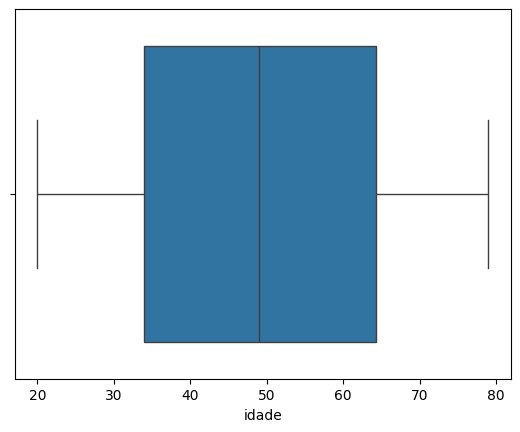

In [16]:
# verificar / detectar outliers - sem outliers no campo "idade"
sns.boxplot(data=df_colesterol_eda, x="idade")

<Axes: xlabel='peso'>

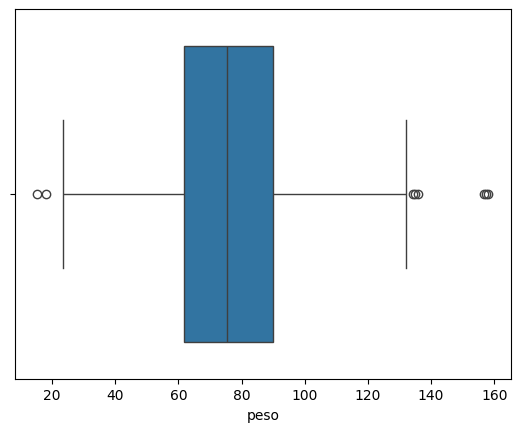

In [17]:
# verificar / detectar outliers - presença de outliers no campo "peso"
sns.boxplot(data=df_colesterol_eda, x="peso")

In [18]:
# Filtrar o público a ser removido
df_colesterol_eda[df_colesterol_eda["peso"] < 40]["peso"].count()

37

In [19]:
df_colesterol_eda.drop(
    df_colesterol_eda[df_colesterol_eda["peso"] < 40].index, axis=0, inplace=True
)
df_colesterol_eda.info()

<class 'pandas.core.frame.DataFrame'>
Index: 963 entries, 0 to 999
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   grupo_sanguineo         960 non-null    object 
 1   fumante                 963 non-null    object 
 2   nivel_atividade_fisica  963 non-null    object 
 3   idade                   963 non-null    int32  
 4   peso                    963 non-null    float64
 5   altura                  963 non-null    int32  
 6   nivel_colesterol        963 non-null    float64
dtypes: float64(2), int32(2), object(3)
memory usage: 52.7+ KB


<Axes: xlabel='altura'>

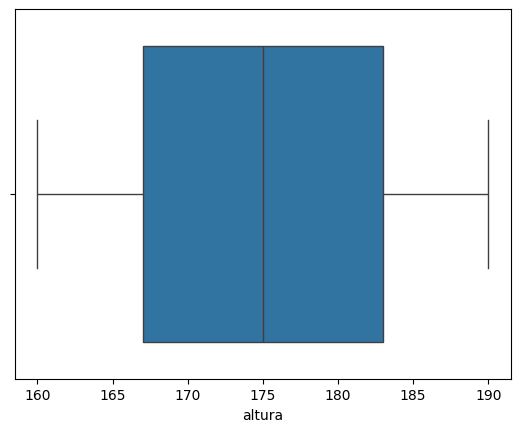

In [20]:
# verificar / detectar outliers - sem presença de outliers no campo "altura"
sns.boxplot(data=df_colesterol_eda, x="altura")

<Axes: xlabel='nivel_colesterol'>

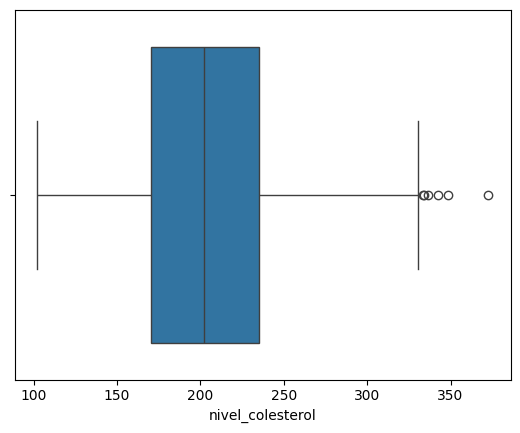

In [21]:
# verificar / detectar outliers - sem outliers no campo "colesterol"
sns.boxplot(data=df_colesterol_eda, x="nivel_colesterol")

#### Análise Grafica



Neste vídeo, continuamos nossa análise exploratória de dados, agora focando em cruzamentos entre variáveis categóricas e o nível de colesterol. Utilizamos o boxplot para visualizar a variação do nível de colesterol de acordo com diferentes categorias, como grupo sanguíneo, tabagismo e nível de atividade física. Observamos que o grupo sanguíneo pode influenciar o nível de colesterol, com os tipos O e B apresentando níveis menores em comparação aos tipos A e AB. Além disso, identificamos que fumantes tendem a ter níveis mais altos de colesterol, enquanto pessoas com alto nível de atividade física apresentam níveis mais baixos. Esses padrões são importantes para a construção do modelo preditivo. Observamos que, em geral, há uma tendência de que quanto maior o peso, maior o nível de colesterol. No entanto, também identificamos outliers, ou seja, valores de colesterol muito altos para pesos muito altos. Se encontrássemos casos de pessoas com pesos altos e níveis de colesterol baixos, seria algo estranho. Em seguida, analisamos a relação entre a altura e o nível de colesterol, e não encontramos um padrão claro. Concluímos essa parte da análise e nos preparamos para a próxima etapa, que é cruzar as variáveis numéricas com a variável dependente, o nível de colesterol.Utilizaremos o Seaborn para criar um gráfico chamado pairplot, que mostrará a distribuição das variáveis e suas correlações visuais. Observamos que o peso tem uma correlação positiva com o nível de colesterol, ou seja, quanto maior o peso, maior o nível de colesterol. A altura e a idade estão bem distribuídas ao longo do conjunto de dados. Não encontramos outras correlações significativas entre as variáveis independentes, o que é bom para evitar multicolinearidade em nosso modelo.



<Axes: xlabel='grupo_sanguineo', ylabel='nivel_colesterol'>

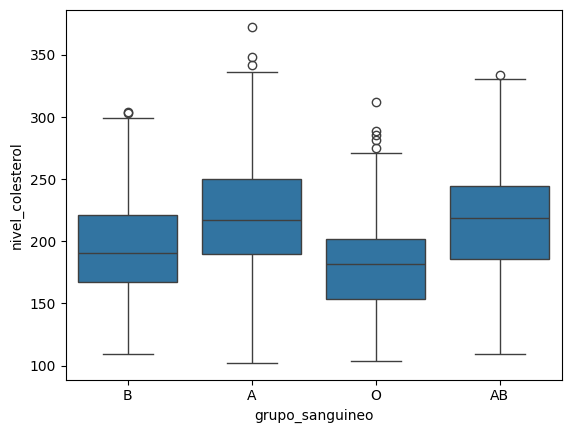

In [22]:
# cruzamento de variáveis categoricas - nível de colesterol
sns.boxplot(data=df_colesterol_eda, x="grupo_sanguineo", y="nivel_colesterol")

<Axes: xlabel='fumante', ylabel='nivel_colesterol'>

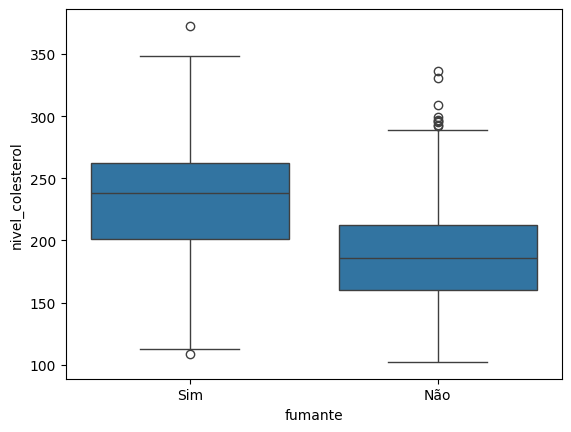

In [23]:
# cruzamento de variáveis categoricas - fumantes
sns.boxplot(data=df_colesterol_eda, x="fumante", y="nivel_colesterol")

<Axes: xlabel='nivel_atividade_fisica', ylabel='nivel_colesterol'>

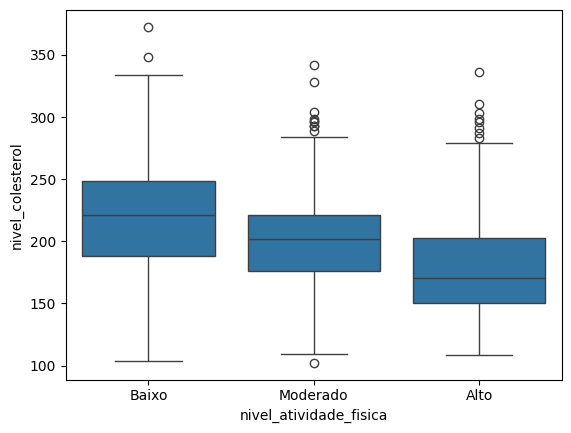

In [24]:
# cruzamento de variáveis categoricas - atividade física
sns.boxplot(data=df_colesterol_eda,
            x="nivel_atividade_fisica", y="nivel_colesterol")

<Axes: xlabel='idade', ylabel='nivel_colesterol'>

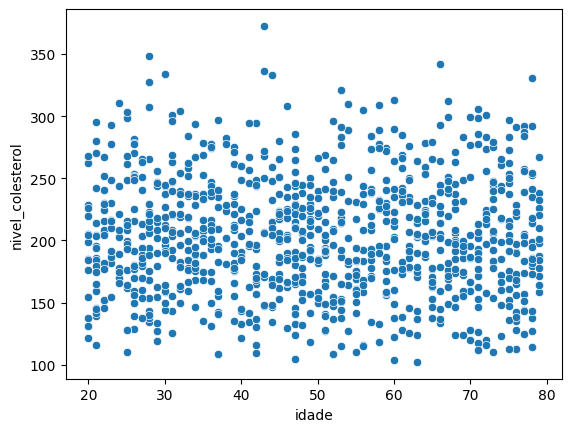

In [25]:
# cruzamento variáveis numéricas com nível de colesterol - idade
sns.scatterplot(data=df_colesterol_eda, x="idade", y="nivel_colesterol")

<Axes: xlabel='peso', ylabel='nivel_colesterol'>

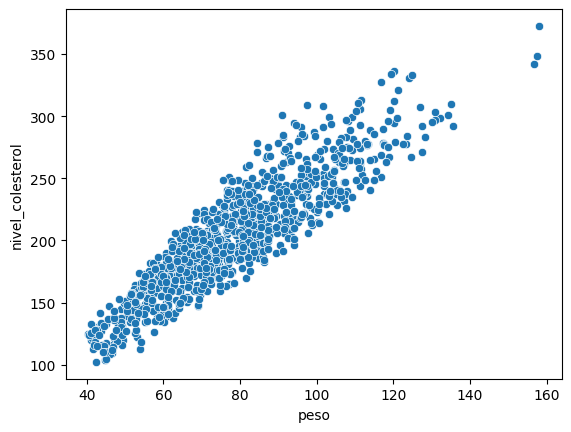

In [26]:
# cruzamento variáveis numéricas com nível de colesterol - peso
sns.scatterplot(data=df_colesterol_eda, x="peso", y="nivel_colesterol")

<Axes: xlabel='altura', ylabel='nivel_colesterol'>

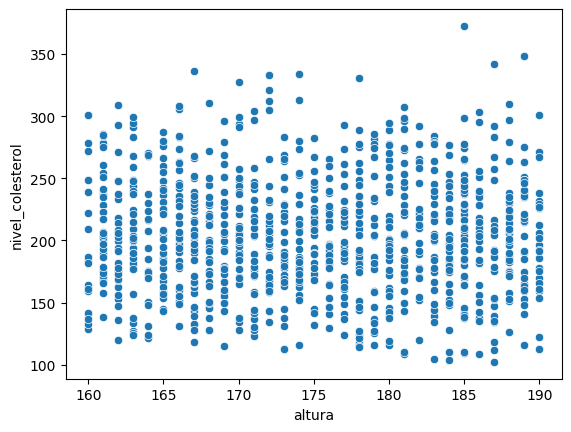

In [27]:
# cruzamento variáveis numéricas com nível de colesterol - altura
sns.scatterplot(data=df_colesterol_eda, x="altura", y="nivel_colesterol")

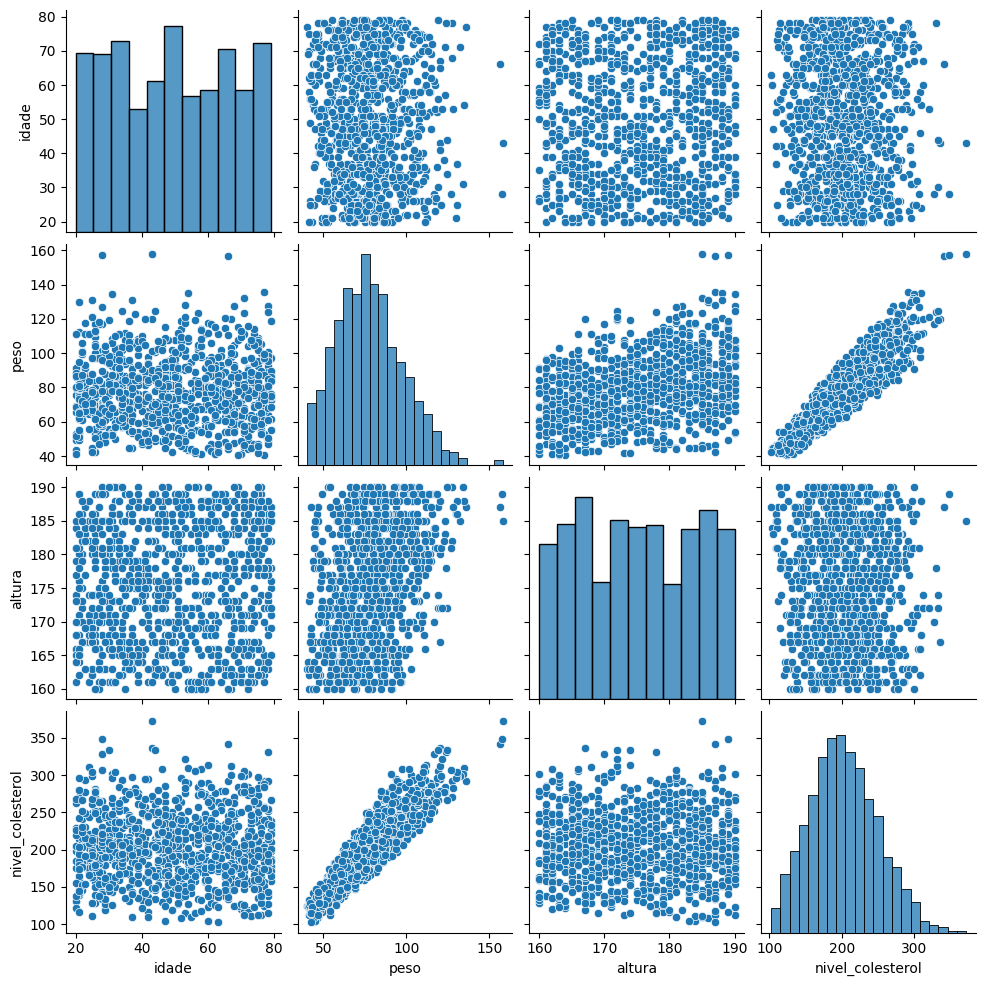

In [28]:
# cruzamento de todas as variáveis numéricas - modo rápido
sns.pairplot(df_colesterol_eda)

#### Análise de Correlação



Nesta aula, aprendemos como converter variáveis categóricas em numéricas para análise de correlação. Utilizamos o método `get_dummies` do Pandas para converter as variáveis nominais, como fumante e grupo sanguíneo, em variáveis binárias. Em seguida, utilizamos o método `factorize` para converter a variável ordinal de nível de atividade física em valores numéricos. Com o DataFrame preparado, plotamos um heatmap de correlação usando o Seaborn, onde observamos as correlações entre as variáveis. Identificamos que o peso tem uma correlação forte com o nível de colesterol, assim como o fato de ser fumante e o tipo sanguíneo. Também notamos uma correlação negativa entre o nível de colesterol e o nível de atividade física.



In [29]:
# converter variáveis categóricas nominais em numéricas usando One-Hot Enconder do Pandas
df_colesterol_eda = pd.get_dummies(
    df_colesterol_eda, columns=["grupo_sanguineo", "fumante"], dtype="int64"
)

In [30]:
df_colesterol_eda.head(5)

,nivel_atividade_fisica,idade,peso,altura,nivel_colesterol,grupo_sanguineo_A,grupo_sanguineo_AB,grupo_sanguineo_B,grupo_sanguineo_O,fumante_Não,fumante_Sim
0,Baixo,33,85.1,186,199.63,0,0,1,0,0,1
1,Moderado,68,105.0,184,236.98,1,0,0,0,1,0
2,Alto,25,64.8,180,161.79,0,0,0,1,1,0
3,Alto,43,120.2,167,336.24,1,0,0,0,1,0
4,Baixo,79,88.5,175,226.23,0,1,0,0,1,0


In [31]:
# converter variável categórica em numérica ordinal em numérica usando factorize
df_colesterol_eda["nivel_atividade_fisica"] = (
    pd.factorize(df_colesterol_eda["nivel_atividade_fisica"])[0] + 1
)
df_colesterol_eda.head(3)

,nivel_atividade_fisica,idade,peso,altura,nivel_colesterol,grupo_sanguineo_A,grupo_sanguineo_AB,grupo_sanguineo_B,grupo_sanguineo_O,fumante_Não,fumante_Sim
0,1,33,85.1,186,199.63,0,0,1,0,0,1
1,2,68,105.0,184,236.98,1,0,0,0,1,0
2,3,25,64.8,180,161.79,0,0,0,1,1,0


<Axes: >

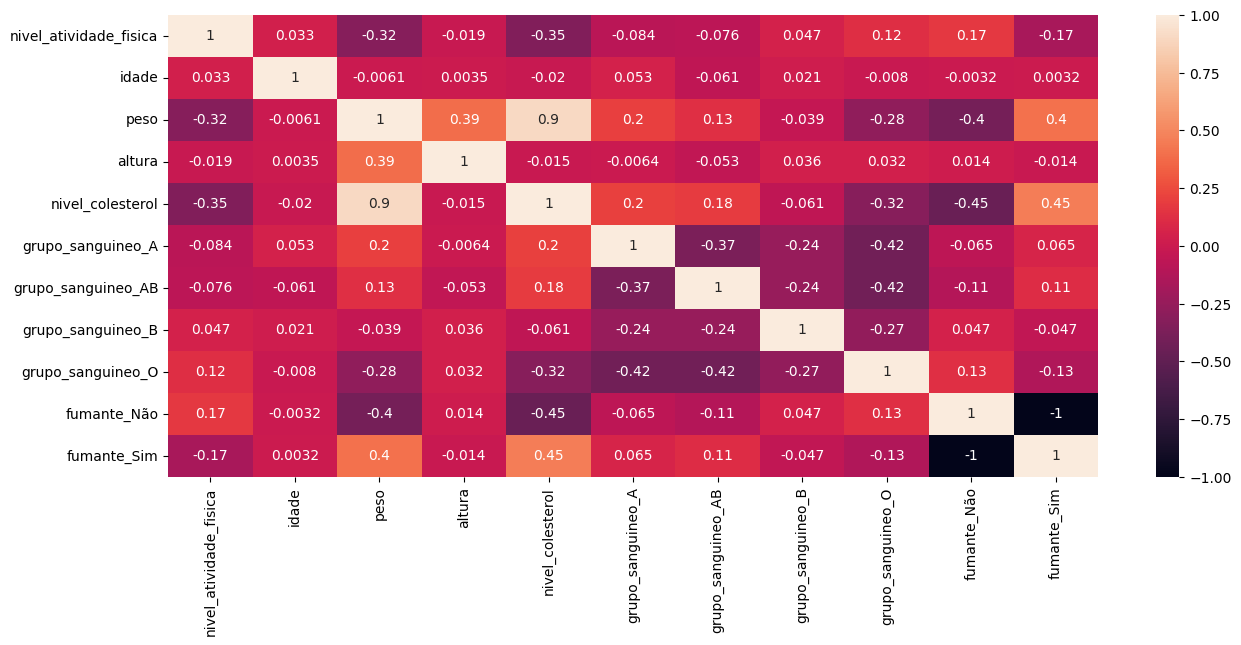

In [32]:
# mapa de calor com correlação entre variáveis
# peso tem uma correlação muito alta
plt.figure(figsize=(15, 6))
sns.heatmap(df_colesterol_eda.corr(), vmin=-1, vmax=1, annot=True)

<Axes: >

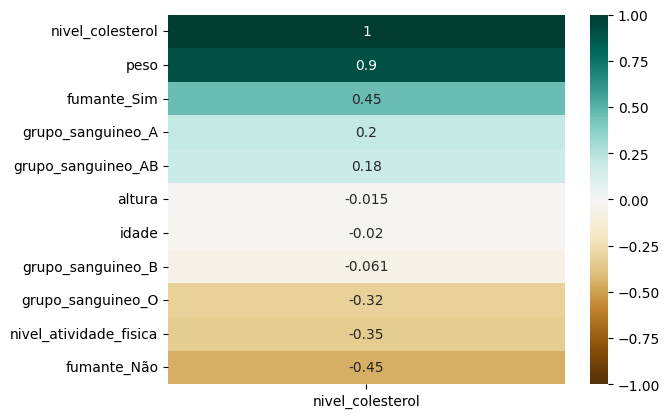

In [33]:
# formato de ranking, somente correlação com a variável target (nível correlação)
sns.heatmap(
    df_colesterol_eda.corr()[["nivel_colesterol"]].sort_values(
        by="nivel_colesterol", ascending=False
    ),
    vmin=-1,
    vmax=1,
    annot=True,
    cmap="BrBG",
)

#### Análise Gráfica com Bucketing



Nesta aula, aprendemos sobre o conceito de bucketing e como aplicá-lo usando a biblioteca Pandas em Python. O bucketing é útil quando queremos analisar ranges de valores em vez de valores individuais. No exemplo dado, criamos buckets para a variável idade, dividindo-a em faixas de 10 anos. Também mostramos como fazer o mesmo para a variável peso. Em seguida, utilizamos gráficos de boxplot para visualizar os agrupamentos e identificar possíveis padrões ou outliers. No caso da idade, não encontramos um padrão claro em relação ao nível de colesterol, ao contrário do que aconteceu com o peso.



In [34]:
# Bucketing - idade
bins_idade = [10, 20, 30, 40, 50, 60, 70, 80]
labels_idade = ["10-19", "20-29", "30-39", "40-49", "50-59", "60-69", "70-79"]
df_colesterol_bucketing["escala_idade"] = pd.cut(
    x=df_colesterol_bucketing["idade"],
    bins=bins_idade,
    labels=labels_idade,
    include_lowest=True,
)
df_colesterol_bucketing.head(5)

,grupo_sanguineo,fumante,nivel_atividade_fisica,idade,peso,altura,nivel_colesterol,escala_idade
0,B,Sim,Baixo,33.0,85.1,186.0,199.63,30-39
1,A,Não,Moderado,68.0,105.0,184.0,236.98,60-69
2,O,Não,Alto,25.0,64.8,180.0,161.79,20-29
3,A,Não,Alto,43.0,120.2,167.0,336.24,40-49
4,AB,Não,Baixo,79.0,88.5,175.0,226.23,70-79


<Axes: xlabel='escala_idade', ylabel='nivel_colesterol'>

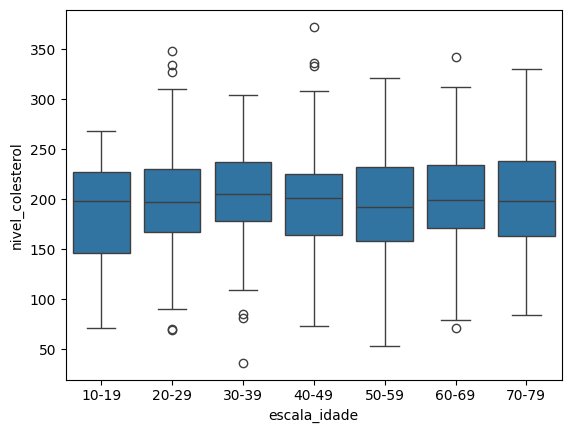

In [35]:
# Boxplot com faixas de idade
sns.boxplot(df_colesterol_bucketing, x="escala_idade", y="nivel_colesterol")

In [36]:
# Bucketing - peso
bins_peso = [30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160]
labels_peso = [
    "30-39",
    "40-49",
    "50-59",
    "60-69",
    "70-79",
    "80-89",
    "90-99",
    "100-109",
    "110-119",
    "120-129",
    "130-139",
    "140-149",
    "150-159",
]
df_colesterol_bucketing["escala_peso"] = pd.cut(
    x=df_colesterol_bucketing["peso"],
    bins=bins_peso,
    labels=labels_peso,
    include_lowest=True,
)
df_colesterol_bucketing.head(7)

,grupo_sanguineo,fumante,nivel_atividade_fisica,idade,peso,altura,nivel_colesterol,escala_idade,escala_peso
0,B,Sim,Baixo,33.0,85.1,186.0,199.63,30-39,80-89
1,A,Não,Moderado,68.0,105.0,184.0,236.98,60-69,100-109
2,O,Não,Alto,25.0,64.8,180.0,161.79,20-29,60-69
3,A,Não,Alto,43.0,120.2,167.0,336.24,40-49,120-129
4,AB,Não,Baixo,79.0,88.5,175.0,226.23,70-79,80-89
5,B,Não,Baixo,68.0,66.8,170.0,185.31,60-69,60-69
6,A,Sim,Baixo,60.0,117.3,181.0,289.33,50-59,110-119


<Axes: xlabel='escala_peso', ylabel='nivel_colesterol'>

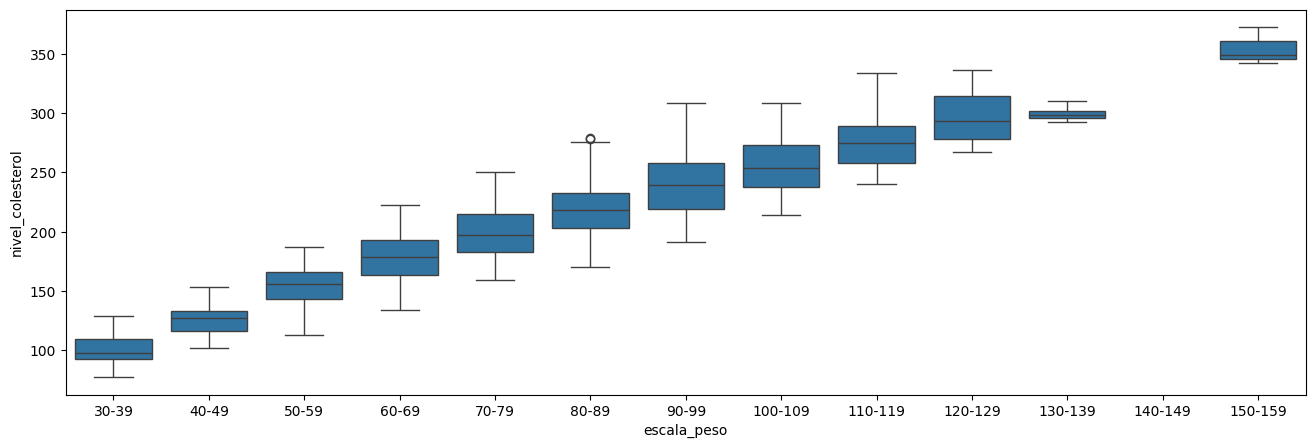

In [37]:
# Boxplot com faixas de peso
plt.figure(figsize=(16, 5))
sns.boxplot(df_colesterol_bucketing, x="escala_peso", y="nivel_colesterol")

### Preparação do Dataset para Treinamento



#### Split do Dataset Treino e Teste



Nesta aula, vamos começar a treinar nosso modelo de predição de colesterol com base em um conjunto de dados. Para isso, vamos utilizar o conceito de pipeline do sklearn, que nos ajuda a automatizar o processo de transformação das variáveis independentes antes de entrar no modelo. Vamos importar os módulos necessários do sklearn, como o modelSelection, linear regression e preprocessing. Também vamos utilizar o column transformer para transformar as colunas de acordo com nossa necessidade. Além disso, vamos tratar os valores ausentes e importar as métricas r2score, minabsoluteerror e minsquarederror. Após preparar o dataframe e fazer o split dos dados de treino e teste, vamos construir o pipeline para treinar nosso modelo.



In [38]:
# Criar dataset e treino de teste - remover principais outliers
df_colesterol.drop(
    df_colesterol[df_colesterol["peso"] < 40].index, axis=0, inplace=True
)
df_colesterol.info()

<class 'pandas.core.frame.DataFrame'>
Index: 963 entries, 0 to 999
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   grupo_sanguineo         960 non-null    object 
 1   fumante                 960 non-null    object 
 2   nivel_atividade_fisica  959 non-null    object 
 3   idade                   960 non-null    float64
 4   peso                    960 non-null    float64
 5   altura                  960 non-null    float64
 6   nivel_colesterol        963 non-null    float64
dtypes: float64(4), object(3)
memory usage: 60.2+ KB


In [39]:
# definir variáveis de treino - independentes e dependente
X = df_colesterol.drop(columns="nivel_colesterol", axis=1)
Y = df_colesterol["nivel_colesterol"]

In [40]:
# Split
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.30, random_state=51
)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(674, 6) (289, 6) (674,) (289,)


#### Transformação de Variáveis Categóricas para o Modelo



Nesta aula, vamos aprender sobre a importância de padronizar e codificar variáveis em um pipeline de transformação de dados. Primeiro, discutimos a necessidade de padronizar variáveis numéricas, como idade, altura e peso, para que todas estejam na mesma escala. Em seguida, explicamos a importância de codificar variáveis categóricas nominais usando o método `one-hot encode` e variáveis categóricas ordinais usando o método ordinal encoder. Além disso, mencionamos a importância de imputar valores ausentes usando a mediana para variáveis numéricas. Por fim, mostramos como organizar um pipeline de transformação, criando uma lista de colunas para cada tipo de variável e definindo os passos de transformação para cada categoria.



In [41]:
# PIPELINE
# imputar moda nas variáveis categóricas - grupo sanguineo, fumante, nível_atividade_fisica
# Padronizar variáveis numéricas - idade, altura, peso
# OneHotEncoder - variáveis categóricas nominais - grupo_saguineo, fumante
# OrdinalEncoder - variáveis categóricas ordinais - nível_atividade_fisica

# nome das colunas
colunas_categoricas = ["grupo_sanguineo", "fumante"]
colunas_numericas = ["idade", "altura", "peso"]
colunas_ordinais = ["nivel_atividade_fisica"]

In [42]:
# trasformar variáveis categóricas
transformer_categorias = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

#### Transformação de Variáveis Ordinais e Numéricas para o Modelo



Neste vídeo, continuamos a nossa pipeline criando um Transformer para as variáveis ordinais. O Transformer irá realizar a mesma função do Imputer, preenchendo os valores ausentes com a moda. A diferença é que precisamos definir a ordem das categorias, que são baixa, moderada e alta. Em seguida, criamos um Transformer numérico, utilizando a mediana como estratégia de preenchimento dos valores ausentes. Em vez de usar um encoder, utilizamos um Scalar, especificamente o Standard Scalar, para converter os valores para a escala Z. Após criar esses três Transformers, encapsulamos todos eles em um Column Transformer, que será o pré-processador antes de treinar o modelo.



In [43]:
# transformar variáveis ordinais
transformer_ordinais = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        (
            "ordinal",
            OrdinalEncoder(
                categories=[["Baixo", "Moderado", "Alto"]], handle_unknown="error"
            ),
        ),
    ]
)

In [44]:
# transformar variáveis numéricas
transformer_numericas = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

In [45]:
# Criar um ColumnTransformer que encapsula todas as transformações
preprocessor = ColumnTransformer(
    transformers=[
        ("num", transformer_numericas, colunas_numericas),
        ("cat", transformer_categorias, colunas_categoricas),
        ("ord", transformer_ordinais, colunas_ordinais),
    ]
)

### Treinamento do Modelo com Pipelines



Nesta aula, criamos um Pipeline principal para pré-processar os dados e treinar um modelo de regressão linear. O Pipeline é composto por dois steps: o pré-processamento, que transforma as colunas no formato necessário, e o treinamento do modelo. Utilizamos o objeto Pipeline para criar essa estrutura. Em seguida, treinamos o modelo utilizando o método fit, passando o conjunto de treinamento. O Pipeline executa todas as etapas de uma vez, incluindo o pré-processamento e a regressão linear. Podemos visualizar a estrutura do Pipeline e analisar as métricas do modelo treinado.



In [46]:
# criar o pipeline principal - preprocessamento + treinamento
model_regr = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", LinearRegression())]
)

In [47]:
# treinar modelo
model_regr.fit(X_train, Y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['idade', 'altura', 'peso']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['grupo_sanguineo',
                                                   'fumante']),
                                                 ('ord',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(categories=[['Baixo',
                                                                                               'Moderado',
                                                                                               'Alto']]))]),
                                                  ['nivel_atividade_fisica'])])),
                ('regressor', LinearRegression())])

### Validação do Modelo



#### Análise de Métricas



Nesta aula, vamos analisar as métricas do nosso modelo de predição. Primeiro, vamos gerar a predição usando o conjunto de teste. Em seguida, calcularemos o R2Score, que mede o quão bem as variáveis independentes explicam a variância da variável dependente. Um valor próximo de 1 indica um bom modelo. Também calcularemos o MinAbsoluteError, que mede a diferença média entre os valores preditos e reais, e o RMSE, que leva em conta os outliers. Vamos analisar essas métricas para avaliar a qualidade do nosso modelo.



In [48]:
# gerar predição
Y_pred = model_regr.predict(X_test)

In [49]:
# calcular r2_score - quanto mais próximo de 1, melhor
r2_score(Y_test, Y_pred)
# pelo índice, temos um bom modelo

0.9594250724093464

In [50]:
# calcular predição de erro do modelo
# MAE (mean_absolute_error)
# o valor apresenta a mesma unidade da variável dependente
print(f"{mean_absolute_error(Y_test, Y_pred):.2f} mg/dL, para mais ou para menos")

7.31 mg/dL, para mais ou para menos


In [51]:
# calcular RMSE (root mean absolute error)
# outliers evidenciam a diferença com o resultado do índice anterior
mean_squared_error(Y_test, Y_pred, squared=False)

9.097649246487032

#### Análise Gráfica de Resíduos



Nesta aula, vamos analisar os resíduos do nosso modelo de regressão. Vamos calcular os resíduos e transformá-los na escala padrão. Em seguida, faremos uma análise gráfica para verificar a linearidade e a homoscedasticidade dos resíduos. Utilizaremos o scatter plot do Seaborn para plotar o gráfico. Observaremos se os valores estão próximos da reta de 45° e se estão dentro da banda de segurança. Além disso, faremos testes estatísticos para confirmar se os resíduos seguem uma distribuição normal. Utilizaremos o gráfico QQ-Plot do módulo Penguin para verificar a normalidade dos resíduos.



In [52]:
# calcular resíduos
residuos = Y_test - Y_pred
print(residuos.dtype)

float64


In [53]:
# transformar resíduos na escala padrão
# (X - média) / desvio padrão
residuos_std = zscore(residuos)
print(residuos_std.dtype)

float64


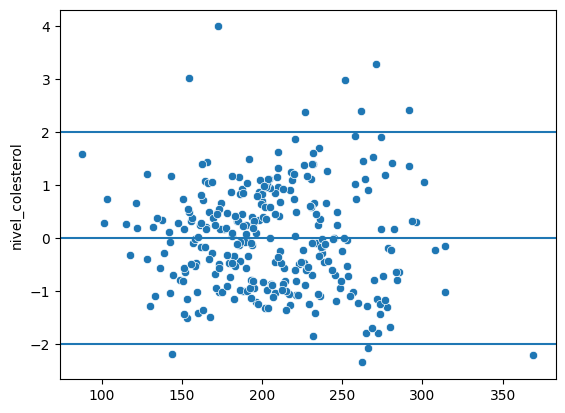

In [54]:
# verificar linearidade dos resíduos: valores entre -2 e +2 (escala padrão)
# verificar homocedasticidade - bem ditribuidos
sns.scatterplot(x=Y_pred, y=residuos_std)
plt.axhline(y=0)
plt.axhline(y=-2)
plt.axhline(y=2)

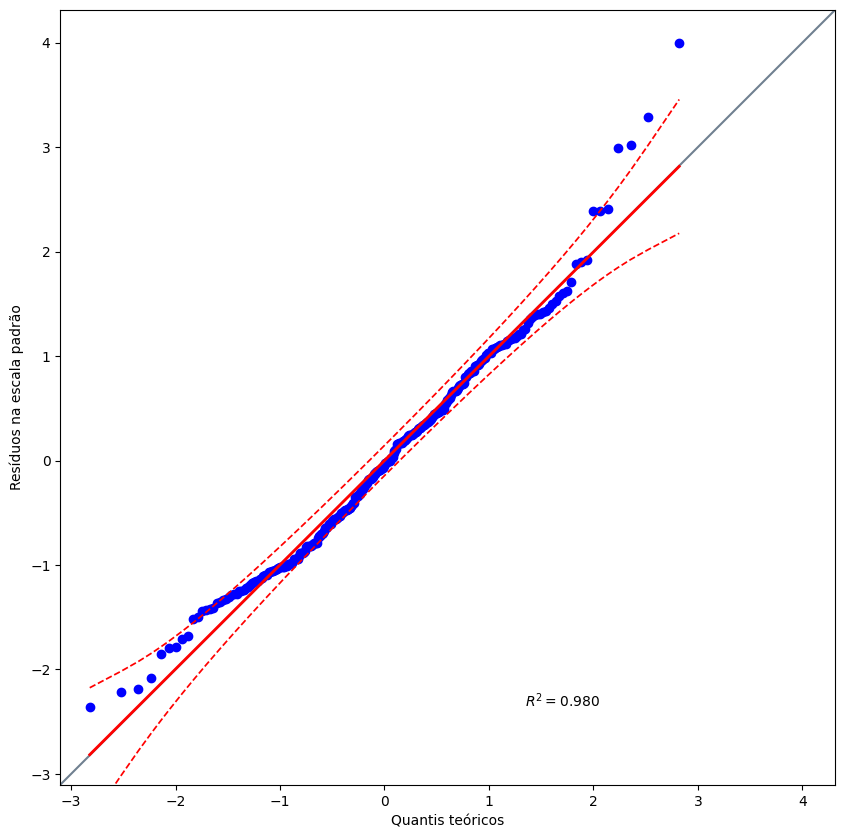

In [55]:
# checar se resíduos seguem uma distribuição normal
# QQ Plot
plt.figure(figsize=(10, 12))
pg.qqplot(residuos_std, dist="norm", confidence=0.95)
plt.xlabel("Quantis teóricos")
plt.ylabel("Resíduos na escala padrão")
plt.show()

#### Teste de Normalidade dos Resíduos



Nesta aula, vamos realizar testes estatísticos para verificar a normalidade dos resíduos. Vamos utilizar os testes de Shapiro-Wilk, Kolmogorov-Smirnov, Lillliefors e Anderson-Darling. Primeiro, importamos os módulos necessários do SciPy e StatsModels. Em seguida, executamos o teste de Shapiro-Wilk, que retorna a estatística do teste e o valor P. Se o valor P for menor que 0.005, podemos rejeitar a hipótese nula de que os resíduos seguem uma distribuição normal. Em seguida, realizamos o teste de Kolmogorov-Smirnov, que também indica a falta de normalidade nos resíduos. Por fim, realizamos o teste de Lillliefors, que indica a normalidade dos resíduos. Para complementar, realizamos o teste de Anderson-Darling, comparando a estatística do teste com os valores críticos para diferentes níveis de significância. Concluímos que três dos quatro testes indicam a falta de normalidade nos resíduos.



In [56]:
# teste de normalidade de Shapiro-Wilk
stat_shapiro, p_value_shapiro = shapiro(residuos)
print(
    "Estatística do Teste: {:.6f} e P-Value: {:.6f}".format(
        stat_shapiro, p_value_shapiro
    )
)
# rejeitar hipótese nula - P-Value < 0.005

Estatística do Teste: 0.980774 e P-Value: 0.000627


In [60]:
# teste de Kolmogorov - Smirnov
stat_ks, p_value_ks = kstest(residuos, "norm")
print(
    "Estatística do Teste: {:.6f} e P-Value: {:.6f}".format(stat_ks, p_value_ks))
# rejeitar hipótese nula - P-Value < 0.005

Estatística do Teste: 0.424559 e P-Value: 0.000000


In [61]:
# teste de Lilliefors
stat_ll, p_value_ll = lilliefors(residuos, dist="norm", pvalmethod="table")
print("Estatística do Teste: {:.6f} e P-Value: {:.6f}".format(stat_ll, p_value_ll))
# resíduos segue uma distribuição normal - P-Value > 0.005

Estatística do Teste: 0.049554 e P-Value: 0.125333


In [63]:
# teste de Anderson-Darling
stat_and, critical_and, significance_and = anderson(residuos, dist="norm")
print(
    "Estatística do Teste: {:.6f} e Valor Crítico: {:.6f}".format(
        stat_and, critical_and[2]
    )
)
# Se o valor estatístico é maior do que o valor crítico, pode-se rejeitar o H0, ou seja, os resíduos não seguem uma distribuição normal

Estatística do Teste: 0.916928 e Valor Crítico: 0.776000


#### Teste de Homocedasticidade dos Resíduos



Nesta aula, discutimos sobre o teste estatístico de homoscedasticidade, especificamente o teste de Goldfeld-Quandt. Para realizar esse teste, é necessário preparar os dados, incluindo os resíduos e as variáveis independentes. Como usamos um pipeline de pré-processamento, precisamos criar um novo pipeline apenas com esse passo. Em seguida, aplicamos o pipeline aos dados de teste e executamos o teste de Goldfeld-Quandt. Os resultados mostraram que não podemos rejeitar a hipótese nula, indicando que os resíduos têm variância homogênea em relação às variáveis independentes. Isso é um bom sinal para o modelo. Com isso, concluímos a análise de resíduos e estamos prontos para fazer previsões e entregar o modelo ao usuário final.



In [66]:
# Teste de Homocedasticidade de Goldfeld-Quandt
pipe = Pipeline(steps=[("preprocessor", preprocessor)])
X_test_transformed = pipe.fit_transform(X_test)

test_goldfeld = het_goldfeldquandt(residuos, X_test_transformed)
stat_goldfeld, p_value_goldfeld = test_goldfeld[0], test_goldfeld[1]
print(
    "Estatística do Teste: {:.6f} e P-Value: {:.6f}".format(
        stat_goldfeld, p_value_goldfeld
    )
)

Estatística do Teste: 0.671614 e P-Value: 0.989396


### Predição de Valores



Nesta parte final do modelo, vamos aprender como fazer uma predição individual usando o modelo que construímos. Vamos passar os valores desejados para o modelo e ver qual valor ele retorna. É importante lembrar que, no nosso caso, temos uma lista de variáveis para passar. Essas variáveis precisam ser convertidas para que possam entrar no modelo. É aí que entra a beleza dos pipelines. Como já criamos um pipeline, ele já está pronto para receber os dados no seu estado natural e fazer a conversão necessária antes de rodar o modelo e nos trazer a predição. Vamos criar um dicionário com os dados que queremos prever, usando os mesmos nomes de variáveis do nosso dataset. Quando salvamos o modelo, ele salva o pipeline inteiro, não apenas o modelo de regressão linear. Vamos salvar o modelo em um arquivo chamado `model_lr_multiple.plk`. Com isso, concluímos a parte de modelagem e salvamos o modelo. No próximo vídeo, mostraremos como criar uma interface visual simples para o usuário interagir com o modelo.


In [69]:
# definir valores aleatórios para exemplo de predição
prediction_random_values = {
    "grupo_sanguineo": "O",
    "fumante": "Não",
    "nivel_atividade_fisica": "Alto",
    "idade": 40,
    "peso": 70,
    "altura": 180,
}
sample_df = pd.DataFrame(prediction_random_values, index=[1])
sample_df

,grupo_sanguineo,fumante,nivel_atividade_fisica,idade,peso,altura
1,O,Não,Alto,40,70,180


In [70]:
# calcular predição
model_regr.predict(sample_df)

array([165.32375099])

In [71]:
# salvar modelo
joblib.dump(model_regr, "../data/model_lr_multiple.plk")

['../data/model_lr_multiple.plk']